# Malaria Detection Using CNN
## *Problem statement*- To detect the presence or absence of malaria in the individual looking at their blood smears.

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.
* In 2020, there were an estimated 241 million cases of malaria worldwide.
* The estimated number of malaria deaths stood at 627 000 in 2020.
* The WHO African Region carries a disproportionately high share of the global malaria burden. In 2020, the region was home to 95% of malaria cases and 96% of malaria deaths. Children under 5 accounted for about 80% of all malaria deaths in the Region.

Malaria is an acute febrile illness caused by Plasmodium parasites, which are spread to people through the bites of infected female Anopheles mosquitoes. There are 5 parasite species that cause malaria in humans, and 2 of these species – *P. falciparum* and *P. vivax* – pose the greatest threat. *P. falciparum* is the deadliest malaria parasite and the most prevalent on the African continent. *P. vivax* is the dominant malaria parasite in most countries outside of sub-Saharan Africa.

### Here we will be using a CNN for classifying the blood smears into 2 classes- "infected" and "uninfected".
### The CNN model consists of 3- convolution layers with 3 fully connected layers for classification.

## Malaria detection can be dificult, here's why-
* Malaria is no longer an epidemic in many parts of this world, so health care providers may not be familiar with the disease. Therefore the Laboratorians may lack experience with malaria and may fail to detect the parasites when examining the blood smears under the microscope
* In a non-immune indivisual, the incubation period is 10-15 days after the mosquito bite.  The first symptoms – fever, headache, and chills – may be mild and difficult to recognize as malaria. If not treated within 24 hours, P. falciparum malaria can progress to severe illness, often leading to death.

## The dataset I am working with is collected from the National library of Medicine ([Link](https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html)). The kaggle page where the data can be found is [here](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria). As a part of the reference, the preprocessing part of the following project is taken from [here](https://www.kaggle.com/code/pankajj/malaria-detection-with-pytorch-test-acc-96-5) and [here](https://jovian.ai/kopyshev/malaria-deep-learning-with-pytorch). The facts about malaria are taken from the [WHO website](https://www.who.int/news-room/fact-sheets/detail/malaria).

# Importing all the necessary libraries

In [1]:
import os
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
# sys.setrecursionlimit(15000)

# Defining the transforms for our image data

In [2]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

# Loading the data into Jupyter Notebook

In [3]:
image_dir = "D:/Jupyter_Notebook/BDA/SEM2/CDS/Project/medical/archive/cell_images/cell_images"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

# Loading the data into Google Colab directly from kaggle

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download iarunava/cell-images-for-detecting-malaria
! unzip /content/cell-images-for-detecting-malaria.zip
image_dir = "/content/cell_images/cell_images"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

# Splitting the data into train, test and validation

In [4]:
test_size = 0.2
valid_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_valid_index = indices[:test_split - 1], indices[test_split - 1:]

valid_split = int(np.floor((valid_size) * num_train))
valid_index, train_index = train_valid_index[:valid_split - 1], train_valid_index[valid_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
test_sampler = SubsetRandomSampler(test_index)


In [5]:
classes=['infected','uninfected']

# Defining all the necessary function for our model

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class MalariaClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

In [8]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        train_loss = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [10]:
device = get_default_device()
device

device(type='cpu')

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Defining our CNN model

In [12]:
class Malaria_detection(MalariaClassificationBase):
    
    def __init__(self):
        super(Malaria_detection, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.flatten(out)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        
        out = self.fc3(out)
        
        return out

### **Note**- As pointed out my instructor, Mrinmay Maharaj, the 1-layer convolution layer wasn't able to minimize the training loss after a certain point in our training. Thus, to reduce the approximation error, he advised me to increase the layer in my convolution. On using a 2-layer convolution, though approximation error seemed to be have been minimized, the validation and testing accuracies seems to be a notch lower that what was expected. Also, the time in computation was longer. This is why I decided to use a 3- layer convolution layer in CNN. A thorough comparison between the different SGD optimizers is given at the end of this code.

### **Note**- With some initial observation, the learning rate and the number of epochs are set to 1e-3 and 30 respectively because they seem to give us the best representation in a reasonable amount of time. 

# A view of the number of parameters in our model

In [13]:
from torchsummary import summary
summary(Malaria_detection(), (3, 120, 120))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 120, 120]           1,216
       BatchNorm2d-2         [-1, 16, 120, 120]              32
              ReLU-3         [-1, 16, 120, 120]               0
         MaxPool2d-4           [-1, 16, 60, 60]               0
            Conv2d-5           [-1, 32, 60, 60]          12,832
       BatchNorm2d-6           [-1, 32, 60, 60]              64
              ReLU-7           [-1, 32, 60, 60]               0
         MaxPool2d-8           [-1, 32, 30, 30]               0
            Conv2d-9           [-1, 64, 30, 30]          18,496
      BatchNorm2d-10           [-1, 64, 30, 30]             128
             ReLU-11           [-1, 64, 30, 30]               0
        MaxPool2d-12           [-1, 64, 15, 15]               0
          Flatten-13                [-1, 14400]               0
           Linear-14                  [

# A visual representation of the data

In [13]:
train_loader = DataLoader(train_set, sampler=train_sampler, batch_size = 64)
valid_loader = DataLoader(train_set, sampler=valid_sampler, batch_size = 32)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size= 58)
print("Images in Test set: {}\nImages in Train set: {}\nImages in Valid set: {}"
      .format(len(test_index), len(train_index),len(valid_index)))

Images in Test set: 5510
Images in Train set: 16538
Images in Valid set: 5510


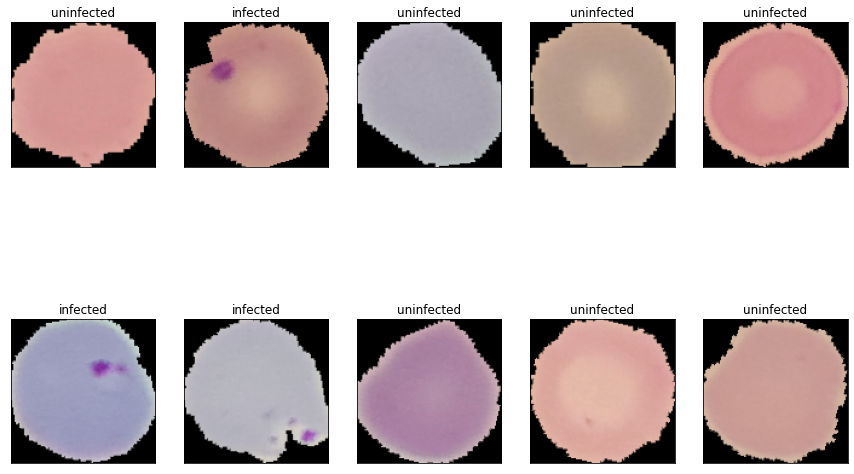

In [14]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    plt.imshow(img.permute(1,2,0))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(15, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

## Moving the dataloader to GPU

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Applying logistic Regression to check the testing accuracy on the current dataset and later use it for comparison

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [ ]:
batch_size = 64
n_iters = 3000
epochs = 30
input_dim = 43200
output_dim = 2
lr_rate = 0.001

In [ ]:
from torch.autograd import Variable
model = LogisticRegression(input_dim, output_dim)
to_device(model, device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
iter = 0
acc = []
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 120 * 120 * 3))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 120*120*3))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
            acc.append(accuracy.cpu().detach().numpy())

Iteration: 500. Loss: 0.5849648118019104. Accuracy: 67.18692779541016.
Iteration: 1000. Loss: 1.5565537214279175. Accuracy: 54.82758331298828.
Iteration: 1500. Loss: 2.1447956562042236. Accuracy: 59.019962310791016.
Iteration: 2000. Loss: 1.2661266326904297. Accuracy: 60.38112258911133.
Iteration: 2500. Loss: 2.718290328979492. Accuracy: 59.43738555908203.
Iteration: 3000. Loss: 1.0719853639602661. Accuracy: 61.070777893066406.
Iteration: 3500. Loss: 1.603710651397705. Accuracy: 55.98910903930664.
Iteration: 4000. Loss: 1.0896880626678467. Accuracy: 54.15607833862305.
Iteration: 4500. Loss: 1.830951452255249. Accuracy: 67.89473724365234.
Iteration: 5000. Loss: 1.4999229907989502. Accuracy: 62.97640609741211.
Iteration: 5500. Loss: 1.5531530380249023. Accuracy: 52.232303619384766.
Iteration: 6000. Loss: 2.443675994873047. Accuracy: 54.30126953125.
Iteration: 6500. Loss: 0.6212953329086304. Accuracy: 67.40471649169922.
Iteration: 7000. Loss: 1.9431710243225098. Accuracy: 52.9582557678222

In [ ]:
print("The average testing accuracy is: ", sum(acc)/len(acc))

The average testing accuracy is:  59.464002990722655


### Due to the lack of computational resources, the Gradient Descent part is skipped

# SGD

The update rule for Stochastic Gradient descent is $ \theta = \theta - \eta \cdot \nabla_\theta J( \theta; x^{(i)}; y^{(i)}) $ where $\theta$ is the parameter, $\eta$ is the learning rate and $x^{(i)}, y^{(i)}$ are training examples and labels respectively.

In [16]:
train_loader = DataLoader(train_set, sampler=train_sampler, batch_size = 1)
train_loader = DeviceDataLoader(train_loader, device)

In [17]:
model = Malaria_detection()
to_device(model, device)
num_epochs = 30
opt_func = torch.optim.SGD
learning_rate = 1e-3
history = fit(num_epochs, learning_rate, model, train_loader, valid_loader, opt_func)

Epoch 0, train_loss: 0.4183, val_loss: 1.7296
Epoch 1, train_loss: 0.3405, val_loss: 1.7748
Epoch 2, train_loss: 0.3375, val_loss: 1.6912
Epoch 3, train_loss: 0.3317, val_loss: 1.5354
Epoch 4, train_loss: 0.3347, val_loss: 1.5254
Epoch 5, train_loss: 0.3311, val_loss: 1.6357
Epoch 6, train_loss: 0.3279, val_loss: 1.7425
Epoch 7, train_loss: 0.3209, val_loss: 1.6232
Epoch 8, train_loss: 0.3202, val_loss: 1.4768
Epoch 9, train_loss: 0.3233, val_loss: 1.7387
Epoch 10, train_loss: 0.3257, val_loss: 1.1448
Epoch 11, train_loss: 0.3215, val_loss: 2.1112
Epoch 12, train_loss: 0.3242, val_loss: 1.8073
Epoch 13, train_loss: 0.3215, val_loss: 1.3284
Epoch 14, train_loss: 0.3204, val_loss: 1.6037
Epoch 15, train_loss: 0.3174, val_loss: 1.4753
Epoch 16, train_loss: 0.3153, val_loss: 1.1576
Epoch 17, train_loss: 0.3194, val_loss: 1.6436
Epoch 18, train_loss: 0.3189, val_loss: 1.1912
Epoch 19, train_loss: 0.3150, val_loss: 1.0829
Epoch 20, train_loss: 0.3165, val_loss: 1.1220
Epoch 21, train_loss: 0

## Plotting the training and the validation loss

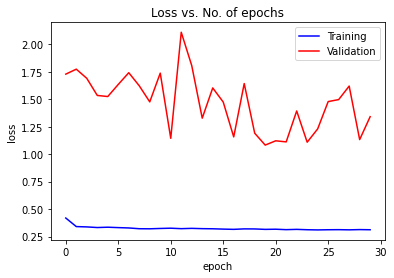

In [18]:
train_losses_sgd = [x.get('train_loss') for x in history]
val_losses_sgd = [x['val_loss'] for x in history]
plt.plot(train_losses_sgd, '-b')
plt.plot(val_losses_sgd, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Plotting the validation accuracy.

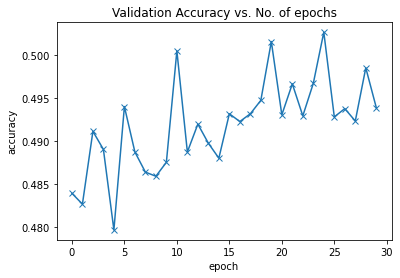

In [19]:
accuracies_sgd = [x['val_acc'] for x in history]
plt.plot(accuracies_sgd, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs')
plt.show()

In [20]:
print("The average validation accuracy is: ", sum(accuracies_sgd)*100/len(accuracies_sgd))

The average validation accuracy is:  49.18934633334478


## testing loop

In [21]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
test_acc_sgd = correct * 100 / total
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 49.06%

Accuracy of infected :  99.93%   [2695 / 2697]
Accuracy of uninfected :  0.28%   [8 / 2813]


### For this case of SGD, we see that the validation loss is very high compared to the training loss. Thus, it is safe to say that the model is not properly trained. It is also clear by looking at the accuracies, both validation and testing. The testing accuracy is 49% which is way less compared to the other SGD algorithms and is also less compared to the logistic regression.
### On increasing the number of epochs to 50, there is no significant change in the output graphs or accuracies and thus for this case, this method is not a good way for loss optimization.

# SGD with mini-batching

The update rule for Stochastic Gradient descent with mini-batching is $ \theta = \theta - \eta \cdot \nabla_\theta J( \theta; x^{(i:i+n)}; y^{(i:i+n)}) $ where $\theta$ is the parameter, $\eta$ is the learning rate and $x^{(i:i+n)}, y^{(i:i+n)}$ are training batch examples and their labels respectively.

In [22]:
train_loader = DataLoader(train_set, sampler=train_sampler, batch_size = 64)
train_loader = DeviceDataLoader(train_loader, device)

In [23]:
model = Malaria_detection()
to_device(model, device)
num_epochs = 30
opt_func = torch.optim.SGD
learning_rate = 1e-3
history = fit(num_epochs, learning_rate, model, train_loader, valid_loader, opt_func)

Epoch 0, train_loss: 0.6639, val_loss: 0.6514
Epoch 1, train_loss: 0.6297, val_loss: 0.6168
Epoch 2, train_loss: 0.6103, val_loss: 0.6011
Epoch 3, train_loss: 0.5866, val_loss: 0.5757
Epoch 4, train_loss: 0.5558, val_loss: 0.5310
Epoch 5, train_loss: 0.5160, val_loss: 0.5159
Epoch 6, train_loss: 0.4791, val_loss: 0.4576
Epoch 7, train_loss: 0.4406, val_loss: 0.4239
Epoch 8, train_loss: 0.4088, val_loss: 0.4003
Epoch 9, train_loss: 0.3878, val_loss: 0.3877
Epoch 10, train_loss: 0.3814, val_loss: 0.3801
Epoch 11, train_loss: 0.3676, val_loss: 0.3622
Epoch 12, train_loss: 0.3689, val_loss: 0.3555
Epoch 13, train_loss: 0.3574, val_loss: 0.3652
Epoch 14, train_loss: 0.3531, val_loss: 0.3554
Epoch 15, train_loss: 0.3574, val_loss: 0.3492
Epoch 16, train_loss: 0.3494, val_loss: 0.3547
Epoch 17, train_loss: 0.3504, val_loss: 0.3550
Epoch 18, train_loss: 0.3499, val_loss: 0.3468
Epoch 19, train_loss: 0.3429, val_loss: 0.3504
Epoch 20, train_loss: 0.3432, val_loss: 0.3515
Epoch 21, train_loss: 0

## Plotting the training and the validation loss

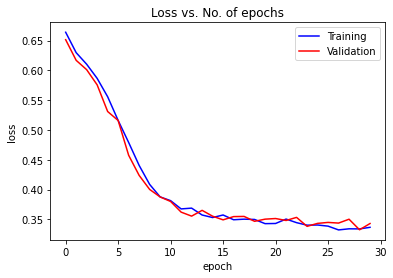

In [24]:
train_losses_mini = [x.get('train_loss') for x in history]
val_losses_mini = [x['val_loss'] for x in history]
plt.plot(train_losses_mini, '-b')
plt.plot(val_losses_mini, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Plotting the validation accuracy.

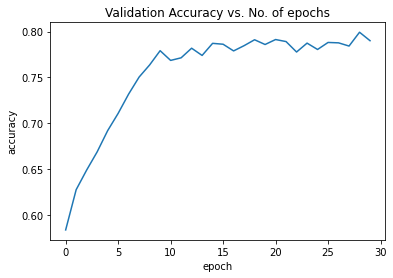

In [25]:
accuracies_mini = [x['val_acc'] for x in history]
plt.plot(accuracies_mini)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs')
plt.show()

In [26]:
print("The average validation accuracy is: ", sum(accuracies_mini)*100/len(accuracies_mini))

The average validation accuracy is:  75.4786862929662


## testing loop

In [27]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
test_acc_mini = correct * 100 / total
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 94.99%

Accuracy of infected :  92.58%   [2497 / 2697]
Accuracy of uninfected :  97.30%   [2737 / 2813]


### In this case of SGD, the convergence is slow and it takes around 11-13 epochs to reach the minimia. The testing accuracy is a notch less that the other algorithms as seen from the results below

# SGD with momentum

The update vector for Stochastic Gradient descent with momentum is 


$\begin{align} 
\begin{split} 
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta) \\ 
\theta &= \theta - v_t 
\end{split} 
\end{align} $

where $\gamma$ is set to 0.9, $\eta$ is the learning rate.

In [28]:
def fit_momentum(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase
        train_loss = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
model = Malaria_detection()
to_device(model, device)
num_epochs = 30
opt_func = torch.optim.SGD
learning_rate = 1e-3
history = fit_momentum(num_epochs, learning_rate, model, train_loader, valid_loader, opt_func)

Epoch 0, train_loss: 0.5729, val_loss: 0.4545
Epoch 1, train_loss: 0.3910, val_loss: 0.3674
Epoch 2, train_loss: 0.3559, val_loss: 0.3528
Epoch 3, train_loss: 0.3524, val_loss: 0.3429
Epoch 4, train_loss: 0.3413, val_loss: 0.3440
Epoch 5, train_loss: 0.3438, val_loss: 0.3444
Epoch 6, train_loss: 0.3314, val_loss: 0.3373
Epoch 7, train_loss: 0.3303, val_loss: 0.3217
Epoch 8, train_loss: 0.3324, val_loss: 0.3250
Epoch 9, train_loss: 0.3321, val_loss: 0.3354
Epoch 10, train_loss: 0.3329, val_loss: 0.3334
Epoch 11, train_loss: 0.3289, val_loss: 0.3388
Epoch 12, train_loss: 0.3236, val_loss: 0.3358
Epoch 13, train_loss: 0.3279, val_loss: 0.3398
Epoch 14, train_loss: 0.3216, val_loss: 0.3340
Epoch 15, train_loss: 0.3248, val_loss: 0.3313
Epoch 16, train_loss: 0.3186, val_loss: 0.3204
Epoch 17, train_loss: 0.3227, val_loss: 0.3393
Epoch 18, train_loss: 0.3187, val_loss: 0.3293
Epoch 19, train_loss: 0.3156, val_loss: 0.3355
Epoch 20, train_loss: 0.3194, val_loss: 0.3209
Epoch 21, train_loss: 0

## Plotting the training and the validation loss

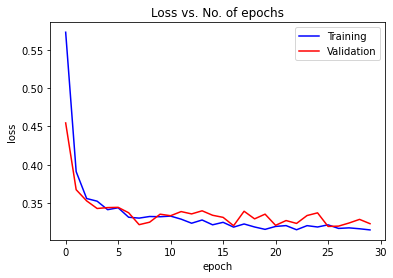

In [30]:
train_losses_mom = [x.get('train_loss') for x in history]
val_losses_mom = [x['val_loss'] for x in history]
plt.plot(train_losses_mom, '-b')
plt.plot(val_losses_mom, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Plotting the validation accuracy.

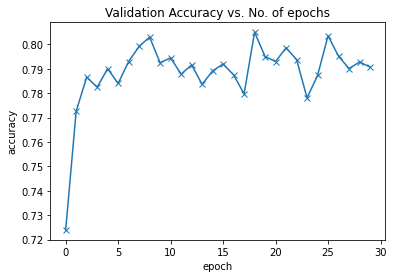

In [31]:
accuracies_mom = [x['val_acc'] for x in history]
plt.plot(accuracies_mom, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs')
plt.show()

In [32]:
print("The average validation accuracy is: ", sum(accuracies_mom)/len(accuracies_mom))

The average validation accuracy is:  0.7884874761104583


## testing loop

In [33]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
test_acc_mom = correct * 100 / total
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 96.12%

Accuracy of infected :  95.92%   [2587 / 2697]
Accuracy of uninfected :  96.30%   [2709 / 2813]


### For SGD with momentum, we are assured with faster convergence and reduced oscillation,which can be seen from the loss plots. Also this method gives us the maximum testing accuracy among all the other methods.

# ASGD

In [34]:
model = Malaria_detection()
to_device(model, device)
num_epochs = 30
opt_func = torch.optim.ASGD
learning_rate = 1e-3
history = fit(num_epochs, learning_rate, model, train_loader, valid_loader, opt_func)

Epoch 0, train_loss: 0.6749, val_loss: 0.6649
Epoch 1, train_loss: 0.6536, val_loss: 0.6492
Epoch 2, train_loss: 0.6401, val_loss: 0.6312
Epoch 3, train_loss: 0.6227, val_loss: 0.6118
Epoch 4, train_loss: 0.6103, val_loss: 0.6045
Epoch 5, train_loss: 0.5952, val_loss: 0.6082
Epoch 6, train_loss: 0.5780, val_loss: 0.5744
Epoch 7, train_loss: 0.5519, val_loss: 0.5359
Epoch 8, train_loss: 0.5125, val_loss: 0.4989
Epoch 9, train_loss: 0.4654, val_loss: 0.4473
Epoch 10, train_loss: 0.4181, val_loss: 0.4069
Epoch 11, train_loss: 0.3928, val_loss: 0.3937
Epoch 12, train_loss: 0.3773, val_loss: 0.3916
Epoch 13, train_loss: 0.3653, val_loss: 0.3853
Epoch 14, train_loss: 0.3621, val_loss: 0.3884
Epoch 15, train_loss: 0.3568, val_loss: 0.3534
Epoch 16, train_loss: 0.3563, val_loss: 0.3584
Epoch 17, train_loss: 0.3500, val_loss: 0.3690
Epoch 18, train_loss: 0.3502, val_loss: 0.3575
Epoch 19, train_loss: 0.3446, val_loss: 0.3640
Epoch 20, train_loss: 0.3442, val_loss: 0.3532
Epoch 21, train_loss: 0

## Plotting the training and the validation loss

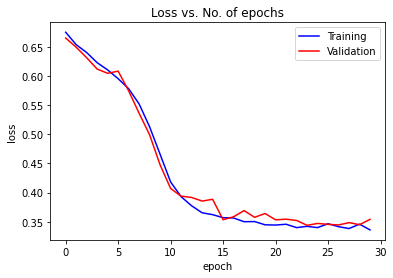

In [35]:
train_losses_asgd = [x.get('train_loss') for x in history]
val_losses_asgd = [x['val_loss'] for x in history]
plt.plot(train_losses_asgd, '-b')
plt.plot(val_losses_asgd, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Plotting the validation accuracy.

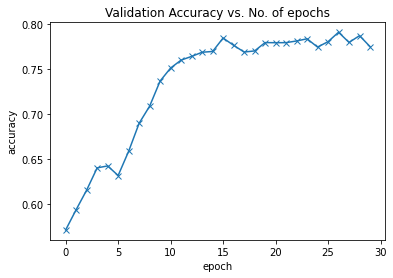

In [36]:
accuracies_asgd = [x['val_acc'] for x in history]
plt.plot(accuracies_asgd, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs')
plt.show()

In [37]:
print("The average validation accuracy is: ", sum(accuracies_asgd)*100/len(accuracies_asgd))

The average validation accuracy is:  73.34738274415334


## testing loop

In [38]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
test_acc_asgd = correct * 100 / total
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 95.25%

Accuracy of infected :  94.99%   [2562 / 2697]
Accuracy of uninfected :  95.49%   [2686 / 2813]


### The rate of convergence is slower and the accuracies is also less than the one we got from SGD with momentum.

# Adam

Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. We compute the decaying averages of past and past squared gradients $m_t$ and $v_t$ respectively as follows:

$\begin{align} 
\begin{split} 
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\ 
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 
\end{split} 
\end{align}$


$m_t$ and $v_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, hence the name of the method. 

In [39]:
model = Malaria_detection()
to_device(model, device)
num_epochs = 30
opt_func = torch.optim.Adam
learning_rate = 1e-3
history = fit(num_epochs, learning_rate, model, train_loader, valid_loader, opt_func)

Epoch 0, train_loss: 0.4913, val_loss: 0.3787
Epoch 1, train_loss: 0.3623, val_loss: 0.3536
Epoch 2, train_loss: 0.3513, val_loss: 0.3443
Epoch 3, train_loss: 0.3410, val_loss: 0.3520
Epoch 4, train_loss: 0.3378, val_loss: 0.3561
Epoch 5, train_loss: 0.3321, val_loss: 0.3370
Epoch 6, train_loss: 0.3367, val_loss: 0.3431
Epoch 7, train_loss: 0.3336, val_loss: 0.3424
Epoch 8, train_loss: 0.3287, val_loss: 0.3274
Epoch 9, train_loss: 0.3283, val_loss: 0.3351
Epoch 10, train_loss: 0.3314, val_loss: 0.3585
Epoch 11, train_loss: 0.3234, val_loss: 0.3382
Epoch 12, train_loss: 0.3222, val_loss: 0.3443
Epoch 13, train_loss: 0.3202, val_loss: 0.3364
Epoch 14, train_loss: 0.3216, val_loss: 0.3330
Epoch 15, train_loss: 0.3272, val_loss: 0.3185
Epoch 16, train_loss: 0.3190, val_loss: 0.3261
Epoch 17, train_loss: 0.3156, val_loss: 0.3353
Epoch 18, train_loss: 0.3173, val_loss: 0.3300
Epoch 19, train_loss: 0.3215, val_loss: 0.3355
Epoch 20, train_loss: 0.3239, val_loss: 0.3266
Epoch 21, train_loss: 0

## Plotting the training and the validation loss

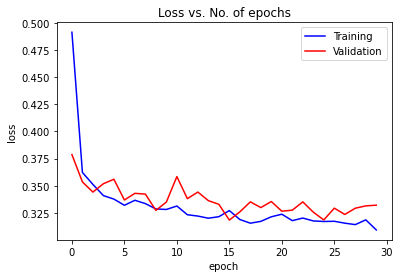

In [40]:
train_losses_adam = [x.get('train_loss') for x in history]
val_losses_adam = [x['val_loss'] for x in history]
plt.plot(train_losses_adam, '-b')
plt.plot(val_losses_adam, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Plotting the validation accuracy.

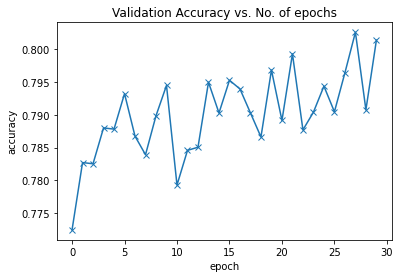

In [41]:
accuracies_adam = [x['val_acc'] for x in history]
plt.plot(accuracies_adam, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs')
plt.show()

In [42]:
print("The average validation accuracy is: ", sum(accuracies_adam)*100/len(accuracies_adam))

The average validation accuracy is:  79.00449633598328


## testing loop

In [43]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
test_acc_adam = correct * 100 / total
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 95.84%

Accuracy of infected :  95.62%   [2579 / 2697]
Accuracy of uninfected :  96.05%   [2702 / 2813]


# Adagrad

The Update rule for Adagrad is given as

$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t, ii} + \epsilon}} \cdot g_{t, i} $

$ G_{t} \in \mathbb{R}^{d \times d}$ here is a diagonal matrix where each diagonal element i,i is the sum of the squares of the gradients w.r.t. $θ_i$ up to time step t, while $\epsilon$ is a smoothing term that avoids division by zero (usually on the order of 1e−8).


In [44]:
model = Malaria_detection()
to_device(model, device)
num_epochs = 30
opt_func = torch.optim.Adagrad
learning_rate = 1e-3
history = fit(num_epochs, learning_rate, model, train_loader, valid_loader, opt_func)

Epoch 0, train_loss: 0.6093, val_loss: 0.6446
Epoch 1, train_loss: 0.4302, val_loss: 0.4214
Epoch 2, train_loss: 0.3836, val_loss: 0.4220
Epoch 3, train_loss: 0.3653, val_loss: 0.3628
Epoch 4, train_loss: 0.3551, val_loss: 0.3474
Epoch 5, train_loss: 0.3505, val_loss: 0.3510
Epoch 6, train_loss: 0.3462, val_loss: 0.3539
Epoch 7, train_loss: 0.3465, val_loss: 0.3440
Epoch 8, train_loss: 0.3454, val_loss: 0.3580
Epoch 9, train_loss: 0.3397, val_loss: 0.3448
Epoch 10, train_loss: 0.3337, val_loss: 0.3396
Epoch 11, train_loss: 0.3375, val_loss: 0.3449
Epoch 12, train_loss: 0.3395, val_loss: 0.3471
Epoch 13, train_loss: 0.3315, val_loss: 0.3509
Epoch 14, train_loss: 0.3334, val_loss: 0.3391
Epoch 15, train_loss: 0.3305, val_loss: 0.3410
Epoch 16, train_loss: 0.3330, val_loss: 0.3420
Epoch 17, train_loss: 0.3325, val_loss: 0.3440
Epoch 18, train_loss: 0.3277, val_loss: 0.3317
Epoch 19, train_loss: 0.3228, val_loss: 0.3472
Epoch 20, train_loss: 0.3314, val_loss: 0.3421
Epoch 21, train_loss: 0

## Plotting the training and the validation loss

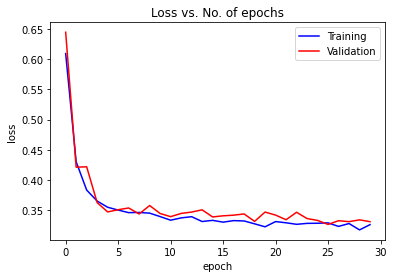

In [45]:
train_losses_ada = [x.get('train_loss') for x in history]
val_losses_ada = [x['val_loss'] for x in history]
plt.plot(train_losses_ada, '-b')
plt.plot(val_losses_ada, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Plotting the validation accuracy.

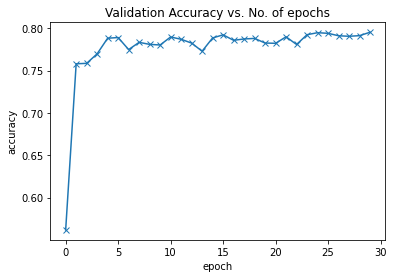

In [46]:
accuracies_ada = [x['val_acc'] for x in history]
plt.plot(accuracies_ada, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs')
plt.show()

In [47]:
print("The average validation accuracy is: ", sum(accuracies_ada)/len(accuracies_ada))

The average validation accuracy is:  0.7768364747365316


## testing loop

In [48]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
test_acc_ada = correct * 100 / total
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 95.63%

Accuracy of infected :  94.66%   [2553 / 2697]
Accuracy of uninfected :  96.55%   [2716 / 2813]


# RMSprop

The update rule of RMSprop is given as 


$\begin{align} 
\begin{split} 
E[g^2]_t &= 0.9 E[g^2]_{t-1} + 0.1 g^2_t \\ 
\theta_{t+1} &= \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t} 
\end{split} 
\end{align}
$

RMSprop as well divides the learning rate by an exponentially decaying average of squared gradients.

In [49]:
model = Malaria_detection()
to_device(model, device)
num_epochs = 30
opt_func = torch.optim.RMSprop
learning_rate = 1e-3
history = fit(num_epochs, learning_rate, model, train_loader, valid_loader, opt_func)

Epoch 0, train_loss: 1.9283, val_loss: 0.5784
Epoch 1, train_loss: 0.5001, val_loss: 0.4504
Epoch 2, train_loss: 0.3787, val_loss: 0.3466
Epoch 3, train_loss: 0.3632, val_loss: 0.3680
Epoch 4, train_loss: 0.3498, val_loss: 0.3381
Epoch 5, train_loss: 0.3435, val_loss: 0.3989
Epoch 6, train_loss: 0.3463, val_loss: 0.3315
Epoch 7, train_loss: 0.3409, val_loss: 0.3276
Epoch 8, train_loss: 0.3370, val_loss: 0.3409
Epoch 9, train_loss: 0.3325, val_loss: 0.3648
Epoch 10, train_loss: 0.3343, val_loss: 0.3274
Epoch 11, train_loss: 0.3327, val_loss: 0.3395
Epoch 12, train_loss: 0.3298, val_loss: 0.3319
Epoch 13, train_loss: 0.3235, val_loss: 0.3328
Epoch 14, train_loss: 0.3247, val_loss: 0.3358
Epoch 15, train_loss: 0.3233, val_loss: 0.4541
Epoch 16, train_loss: 0.3276, val_loss: 0.3537
Epoch 17, train_loss: 0.3259, val_loss: 0.3332
Epoch 18, train_loss: 0.3235, val_loss: 0.3357
Epoch 19, train_loss: 0.3191, val_loss: 0.3727
Epoch 20, train_loss: 0.3189, val_loss: 0.3369
Epoch 21, train_loss: 0

## Plotting the training and the validation loss

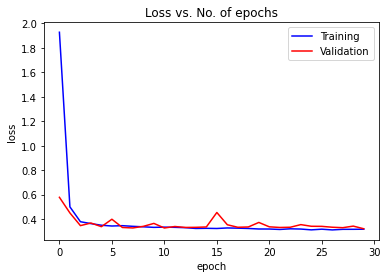

In [50]:
train_losses_rms = [x.get('train_loss') for x in history]
val_losses_rms = [x['val_loss'] for x in history]
plt.plot(train_losses_rms, '-b')
plt.plot(val_losses_rms, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

## Plotting the validation accuracy.

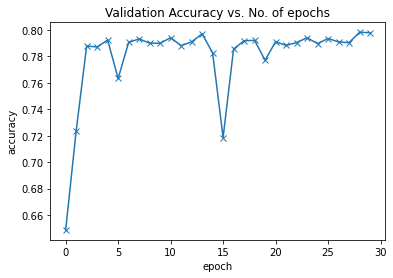

In [51]:
accuracies_rms = [x['val_acc'] for x in history]
plt.plot(accuracies_rms, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs')
plt.show()

In [52]:
print("The average validation accuracy is: ", sum(accuracies_rms)/len(accuracies_rms))

The average validation accuracy is:  0.780407053232193


## testing loop

In [53]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
test_acc_rms = correct * 100 / total
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 95.83%

Accuracy of infected :  95.22%   [2568 / 2697]
Accuracy of uninfected :  96.41%   [2712 / 2813]


### The rate of convergence of the loss curve for the RMSprop seem to be the fastest among all the other algorithms. The accurracy also seems to be on the higher side when compared to the others.

# Comparison of loss and accuracies of the different algorithms. 

In [54]:
test_acc = [test_acc_sgd, test_acc_mini, test_acc_mom, test_acc_asgd, test_acc_adam, test_acc_ada, test_acc_rms]
train_loss = [train_losses_sgd, train_losses_mini, train_losses_mom, train_losses_asgd, train_losses_adam, train_losses_ada,train_losses_rms]
val_loss = [val_losses_sgd, val_losses_mini, val_losses_mom, val_losses_asgd, val_losses_adam, val_losses_ada,val_losses_rms]
val_acc = [accuracies_sgd, accuracies_mini, accuracies_mom, accuracies_asgd, accuracies_adam, accuracies_ada,accuracies_rms]

In [68]:
from statistics import mean
train_loss_mean = []
val_loss_mean = []
val_acc_mean = []

for i in range(7):
    train_loss_mean.append(mean(train_loss[i]))

for i in range(7):
    val_loss_mean.append(mean(val_loss[i]))

for i in range(7):
    val_acc_mean.append(mean(val_acc[i]))


In [92]:
df = pd.DataFrame([train_loss_mean, val_loss_mean, val_acc_mean, test_acc])
df.columns = ['SGD', 'SGD with minibatching', 'SGD with momentum', 'ASGD', 'Adam', 'Adagrad', 'RMSprop']

In [93]:
df.index = ["Training loss", "Validation loss", "Validation accuracy", "Testing accuracy"]
results = df.T
df.index.name = 'Loss Optimizers'
results['Validation accuracy'] = results['Validation accuracy']*100

## A dataframe showing the comparison between all the algorithms done above

In [94]:
results

Loss Optimizers,Training loss,Validation loss,Validation accuracy,Testing accuracy
SGD,0.323689,1.468660,49.189346,49.056261
SGD with minibatching,0.408402,0.406176,75.478686,94.990926
SGD with momentum,0.336675,0.337336,78.848748,96.116152
ASGD,0.433244,0.436064,73.347383,95.245009
Adam,0.331176,0.336847,79.004496,95.843920
Adagrad,0.348784,0.357562,77.683647,95.626134
RMSprop,0.388320,0.357603,78.040705,95.825771
